In [ ]:
#| default_exp stats

# Stats -- Working with all the data

> A simple package for analyzing pklmart data

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
import sys
sys.path.append('..')
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
from pklshop.data import *
from pklshop.name import *
from pklshop.team import *
from pklshop.game import *
from pklshop.player import *

Now let's look at some overall statsitics we can get from the data.

In [ ]:
#| export
def team_first_serve_win_frac(team_id):
    '''
    Takes a team id and returns that team's first serve win fraction.
    '''
    # Get all rallies where the team served the first rally of the game
    rally_fs_df = rally[(rally.rally_nbr == 1) & (rally.srv_team_id == team_id)]
    num_first_serves = len(rally_fs_df)
    #Find the number of games won by the team when they served first
    num_first_serve_games_won = sum(game[game.game_id.isin(rally_fs_df.game_id)].w_team_id == team_id)
    if num_first_serves == 0:
        return 0
    else:
        return num_first_serve_games_won/num_first_serves

In [ ]:
team_id_test = 'T2'
t = Team(team_id_test)
team_win_frac_test = t.num_games_won/t.num_games_played
print("{} won {:.2f}% of games they played".format(get_team_name(team_id_test), team_win_frac_test*100))

Anna Leigh Waters & Leigh Waters won 66.67% of games they played


Let's now look at all the games in the database and sort the teams by their win percentage when serving first.

In [ ]:
fs_win_frac = [team_first_serve_win_frac(team_id) for team_id in team.team_id]
team['fs_win_frac'] = fs_win_frac
team.sort_values('fs_win_frac', ascending=False).head()

,team_id,player_id,player_seq_nbr,team_nm,maint_dtm,maint_app,create_dtm,create_app,fs_win_frac
93,T47,P8,2,Steve Deakin & Matt Wright,2022-11-21 19:35:11.100373+00:00,aspancake,2022-11-21 19:35:11.100373+00:00,aspancake,1.0
74,T38,P59,1,Mike Strain & Payton Noyes,2022-10-16 19:22:34.935319+00:00,postgres,2022-10-16 19:22:34.935319+00:00,postgres,1.0
84,T43,P66,1,Chuck Taylor & AJ Koller,2022-11-07 02:44:58.941454+00:00,aspancake,2022-11-07 02:44:58.941454+00:00,aspancake,1.0
24,T13,P23,1,Collin Johns & Ben Johns,2022-08-08 03:10:56.810337+00:00,postgres,2022-08-08 03:10:56.810337+00:00,postgres,1.0
25,T13,P24,2,Collin Johns & Ben Johns,2022-08-08 03:10:56.815196+00:00,postgres,2022-08-08 03:10:56.815196+00:00,postgres,1.0


Lastly, let's look at the win percentage when serving first, marginalized over all games

In [ ]:
#| export
def get_first_serve_team(game_id: str):
    '''
    Returns the team_id of the team that served first for a given game with game_id.
    '''
    return rally[(rally.game_id == game_id) & (rally.rally_nbr == 1)].srv_team_id.values[0]

def get_frac_first_serve_wins(game_df):
    '''
    Returns the fraction of games won by the first searver for a given df of games.
    '''
    count = 0
    for game_id in game_df.game_id:
        if (game_df[game_df.game_id == game_id].w_team_id == get_first_serve_team(game_id)).values[0]:
            count +=1 
    return count/len(game_df)

In [ ]:
first_serve_win_frac = get_frac_first_serve_wins(game)
print("The first serving team won {:.2f}% of games".format(first_serve_win_frac*100))

The first serving team won 57.41% of games


Let's see how Jessie Irvine compares to the average

In [ ]:
#| export
def get_teams_from_player(player_id: str):
    '''
    Returns the team_ids of the teams that a player with player_id played for.
    '''
    return team[team.player_id == player_id].team_id.values

def team_win_frac(team_id: str):
    '''
    Returns the fraction of games won by a team with team_id.
    '''
    t = Team(team_id)
    return t.num_games_won/t.num_games_played

In [ ]:
players.head()

,player_id,first_nm,last_nm,supp_nm,gender,dom_hand,maint_dtm,maint_app,create_dtm,create_app
0,P61,Gizmo,Hall,NaN,M,R,2022-11-07 02:44:59.019000+00:00,aspancake,2022-11-07 02:44:59.019000+00:00,aspancake
1,P62,Ryan,Kane,NaN,M,R,2022-11-07 02:44:59.019000+00:00,aspancake,2022-11-07 02:44:59.019000+00:00,aspancake
2,P63,Brandon,Ward,NaN,M,R,2022-11-07 02:44:59.019000+00:00,aspancake,2022-11-07 02:44:59.019000+00:00,aspancake
3,P64,Daniel,McNally,NaN,M,R,2022-11-07 02:44:59.019000+00:00,aspancake,2022-11-07 02:44:59.019000+00:00,aspancake
4,P65,Arpit,Dhir,NaN,M,R,2022-11-07 02:44:59.019000+00:00,aspancake,2022-11-07 02:44:59.019000+00:00,aspancake


In [ ]:
player_name_test = "Jesse Irvine"
# player_id_test = get_player_id_from_name(player_name_test)
player_id_test = get_player_id(player_name_test)

In [ ]:
player_id_test

'P1'

In [ ]:
#Find the teams that Jesse Irvine played for
team_ids_test = get_teams_from_player(player_id_test)
for team_id in team_ids_test:
    print(get_team_name(team_id))

Jesse Irvine & Catherine Parenteau
Jesse Irvine & Anna Bright
Jesse Irvine & Lucy Kovalova


In [ ]:
#| export
def games_played_by_team(team_id):
    '''
    Returns the number of games played by a team with team_id.
    '''
    return len(game[(game.w_team_id == team_id) | (game.l_team_id == team_id)])

In [ ]:
net_games_played = sum([games_played_by_team(team_id) for team_id in team_ids_test]) #Number of games played by Jesse Irvine on any team
avg_first_serve_win_frac_test = sum([team_first_serve_win_frac(team_id)* games_played_by_team(team_id) for team_id in team_ids_test])/net_games_played #Average first serve win frac for Jesse Irvine
avg_tot_win_frac_test = sum([team_win_frac(team_id)* games_played_by_team(team_id) for team_id in team_ids_test])/net_games_played #Average total win frac for Jesse Irvine
print("{}'s average first serve win percentage is {:.2f}%".format(player_name_test, avg_first_serve_win_frac_test*100))
print("{}'s average overall win percentage is {:.2f}%".format(player_name_test, avg_tot_win_frac_test*100))


Jesse Irvine's average first serve win percentage is 33.33%
Jesse Irvine's average overall win percentage is 66.67%


In [ ]:
colors = sns.color_palette('pastel')

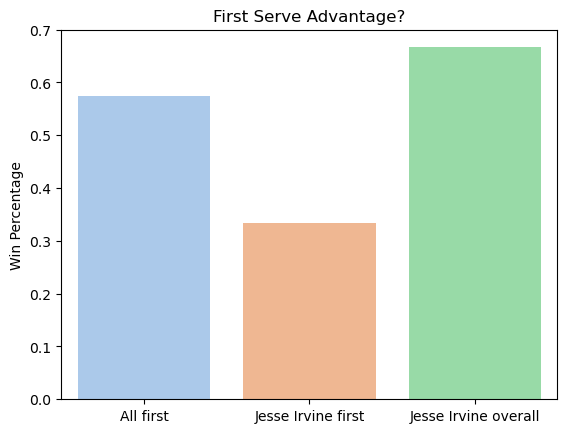

In [ ]:
sns.barplot(x=['All first', player_name_test + " first", player_name_test + " overall"], y=[first_serve_win_frac, avg_first_serve_win_frac_test, avg_tot_win_frac_test], palette=colors)
plt.title("First Serve Advantage?")
plt.ylabel("Win Percentage")
# plt.savefig('figures/first_serve_win_percentage.pdf')
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()